In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import json
import zipfile
import subprocess
import shutil
import getpass
import math
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image,ImageReadMode
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(20)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
dataset_save_dir = './dataset'

In [9]:
def one_hot_encode(val):
    arr = numpy.zeros((6,), dtype=int)
    arr[val] = 1
    return arr

def get_bucket_id(age):
  age_floor = int(age)
  if age_floor >= 0 and age_floor <= 5: return 0
  elif age_floor >= 6 and age_floor <= 12: return 1
  elif age_floor >= 13 and age_floor <= 19: return 2
  elif age_floor >= 20 and age_floor <= 29: return 3
  elif age_floor >= 30 and age_floor <= 59: return 4
  else: return 5

def get_ground_truth(age):
  return one_hot_encode(get_bucket_id(age))

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    torch.cuda.empty_cache()
    size = len(dataloader.dataset)
    model.train()
    loss_tot = 0.0
    num = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
      
        # Forward
        pred = model(X)
        # predSoftmax = nn.Softmax(dim=1)(pred)
        loss = loss_fn(pred,y)

        # print(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tot += loss.item()
        num += 1
        
        X.cpu()
        y.cpu()

    # loss_tot /= num
    print(f'training loss: {(loss_tot):>0.5f}')

In [11]:
validation_accuracy = []
current_max_val_acc = 0.0
def validation(dataloader, model, loss_fn):
    global current_max_val_acc
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    totalsize = 0
    loss_tot = 0.0
    num = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # predSoftmax = nn.Softmax(dim=1)(pred)
            loss = loss_fn(pred,y)
            correct += (pred.argmax(1) == y.argmax(1)).sum().item()
            totalsize += pred.shape[0]
            loss_tot += loss.item()
            num += 1
            X.cpu()
            y.cpu()
            
    print(f"Correct/Total: {correct}/{totalsize}")
    correct /= totalsize
    validation_accuracy.append(correct*100)
    print(f"Validation Loss:  {(loss_tot):>0.5f}")
    print(f"Validation Accuracy: {(100*correct):>0.5f}%\n")
    current_max_val_acc = max(current_max_val_acc,100*correct)
    print(f"Current Best Validation Accuracy: {(current_max_val_acc):>0.5f}%\n")
    return loss_tot

In [12]:
class XRayToothDataset(Dataset):
    def __init__(self, cwd, img_dir, transform=None, target_height=None, target_width=None):
        self.dataset_path = cwd + '/' + img_dir
        self.transform = transform
        self.target_height = target_height
        self.target_width = target_width

    def __len__(self):
        return len(os.listdir(self.dataset_path))

    def __getitem__(self, idx):
        if idx  >= len(os.listdir(self.dataset_path)):
            print("No datafile/image at index : "+ str(idx))
            return None
        img_filename = os.listdir(self.dataset_path)[idx]
        age = float(img_filename.split("_")[1][:-4])
        age_gt = get_ground_truth(age)
        image_tensor = read_image(path=self.dataset_path + '/' + img_filename)
        image_tensor = image_tensor.reshape(1, 3, image_tensor.shape[-2], image_tensor.shape[-1])
        if self.target_height and self.target_width: # Resize the image 
            image_tensor = torch.nn.functional.interpolate(image_tensor, (self.target_height,self.target_width))
        if self.transform: image_tensor = self.transform(image_tensor) # Apply transformations
        image_tensor = (image_tensor-image_tensor.min())/(image_tensor.max()-image_tensor.min())
        return image_tensor.reshape(-1,image_tensor.shape[-2],image_tensor.shape[-1]).to(torch.float32), torch.tensor(age_gt)

In [13]:
# Data Augmentation Transformations 
data_augmentation_transformations = T.RandomChoice([
    T.RandomAffine(degrees=0), # No Augmentation
    T.Lambda(lambda x: TF.hflip(img=x)) # Horizontal Flip

    # Geometric Transformations:
    # T.RandomAffine(degrees=0, scale=(1.3,1.3)), # Scale
    # T.RandomAffine(degrees=0, translate=(0.5,0.5)), # Translate
    # T.RandomAffine(degrees=(-8, 8)), # Rotate
    # T.Lambda(lambda x: TF.hflip(img=x)), # Reflect

    # Occlusion:
    # T.Compose([T.RandomErasing(p=1, scale=(0.0008, 0.0008), ratio=(1,1))]*100), # Occlusion

    # Intensity Operations
    # T.Lambda(lambda x: TF.adjust_gamma(img=x, gamma=0.5)), # Gamma Contrast
    # T.Lambda(lambda x: TF.adjust_contrast(x, contrast_factor=2.0)), # Linear Contrast

    # Filtering:
    # T.Lambda(lambda x: TF.adjust_sharpness(img=x, sharpness_factor=4)), #Sharpen
    # T.GaussianBlur(kernel_size=(15,15), sigma=(0.01, 1)), # Gaussian Blur
])  

In [14]:
training_data = XRayToothDataset(os.getcwd(), img_dir=dataset_save_dir+'/training', transform=data_augmentation_transformations, target_height=224, target_width=224)
validation_data = XRayToothDataset(os.getcwd(), img_dir=dataset_save_dir+'/validation', transform=None, target_height=224, target_width=224)

In [15]:
from torchvision.models import vit_l_32, ViT_L_32_Weights

pretrained_vit = vit_l_32(weights=ViT_L_32_Weights.IMAGENET1K_V1)

In [16]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

pretrained_effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone1 = pretrained_vit
        self.backbone2 = pretrained_effnet

        for param in self.backbone1.parameters():
            param.requires_grad = False

        for param in self.backbone2.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(2000,6)
        )
    
    def forward(self, x):
        x1 = self.backbone1(x)
        x2 = self.backbone2(x)
        x = torch.cat((x1,x2), 1)
        x = self.fc(x)
        return x

In [18]:
model = NeuralNetwork().to(device)

In [19]:
# Test a forward pass
with torch.no_grad():
    print(model(training_data[0][0].reshape(-1,3,224,224).to(device)))

tensor([[ 0.5336, -0.0308, -0.2411,  0.5774,  0.6195, -0.1686]],
       device='cuda:0')


In [20]:
# Training Hyperparameters
epochs = 600
batch_size = 150
learning_rate = 1e-2
momentum=0.9
weight_decay=0.5

In [21]:
training_data_loader = DataLoader(training_data, batch_size, shuffle = True)
validation_data_loader = DataLoader(validation_data, batch_size, shuffle = False)

In [22]:
class CustomNLLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, predicted, ground_truth):
        indices = torch.argmax(ground_truth, dim=1)
        loss = torch.nn.functional.cross_entropy(predicted, indices)
        # selected_probs = torch.gather(predicted, 1, indices.view(-1, 1))
        # loss = -torch.log(selected_probs).mean()
        return loss

In [23]:
loss_function=CustomNLLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9, patience=5, min_lr=1e-4,verbose=True)

In [24]:
# Training
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_data_loader, model, loss_function, optimizer)
    val_loss = validation(validation_data_loader, model, loss_function)
    scheduler.step(val_loss)
    # torch.save(model, 'model.pth')
print("Done!")

Streaming output truncated to the last 5000 lines.
Epoch 50
-------------------------------
training loss: 1.29881
Correct/Total: 81/129
Validation Loss:  0.93592
Validation Accuracy: 62.79070%

Current Best Validation Accuracy: 68.21705%

Epoch 51
-------------------------------
training loss: 1.19432
Correct/Total: 84/129
Validation Loss:  0.93283
Validation Accuracy: 65.11628%

Current Best Validation Accuracy: 68.21705%

Epoch 52
-------------------------------
training loss: 1.35099
Correct/Total: 77/129
Validation Loss:  0.97204
Validation Accuracy: 59.68992%

Current Best Validation Accuracy: 68.21705%

Epoch 53
-------------------------------
training loss: 1.26232
Correct/Total: 78/129
Validation Loss:  0.98263
Validation Accuracy: 60.46512%

Current Best Validation Accuracy: 68.21705%

Epoch 54
-------------------------------
training loss: 1.31202
Correct/Total: 85/129
Validation Loss:  0.97645
Validation Accuracy: 65.89147%

Current Best Validation Accuracy: 68.21705%

Epoc

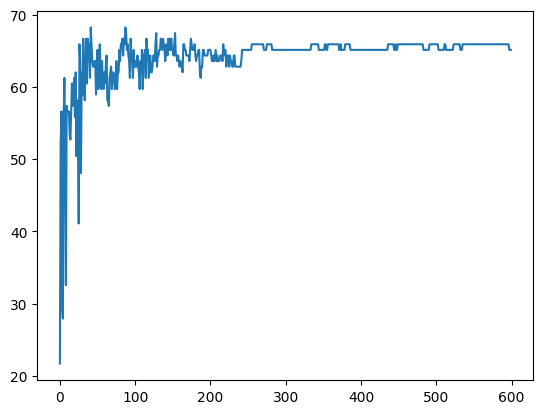

In [25]:
plt.plot(validation_accuracy)

In [26]:
torch.save(model.state_dict(), './drive/MyDrive/exp40_model_600epoch.pth')